In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import pickle
from keras.utils import to_categorical

from pkl_reader import *
from lstm_impl import CombinedLSTM
from kf_impl import EKF_CV_MODEL
from cnn_lstm_impl import CombinedCNNLSTM
from utils import sup_plot, extract_data, get_parking_lot_image_hist, generate_movie

from tfrecord_utils import write_tfrecord, read_tfrecord

from PIL import Image
import traceback

Using TensorFlow backend.


In [23]:
def pkl2tf(file):
    # full dataset for all files_to_process\
    save_ext = 'pkl'
    features_combined = []
    features_global_combined = []
    labels_combined = []
    goal_snpts_combined = []
    static_objs_combined = []

    parking_lot = None
    ego_dims    = None
    
    if save_ext == 'pkl':
        res_dict = pickle.load(open(file,'rb'))
    else:
        raise NotImplemented('Invalid Extension')
    
    goals = extract_goals(res_dict)
    parking_lot = res_dict['parking_lot']
    ego_dims = res_dict['ego_dimensions']
    
    try:
        assert goals.shape[0] == 32, "Invalid goal shape."
        assert len(res_dict['vehicle_object_lists'][0]) == 56, "Wrong number of static vehicles."
        
        # parse one demonstration
        ego_trajectory, start_ind, switch_ind, end_ind, goal_ind = \
             extract_full_trajectory(res_dict, goals, prune_start, prune_end, \
                                     min_vel_thresh, exclude_collisions)

        features, features_global, labels, labels_global, goal_snpts = \
            get_ego_trajectory_prediction_snippets(ego_trajectory, start_ind, switch_ind, end_ind, goal_ind, \
                                           goals, Nhist, Npred, Nskip, dt, ego_frame=ego_trans)
        
        features_combined.extend(features)
        features_global_combined.extend(features_global)
        labels_combined.extend(labels)
        goal_snpts_combined.extend(goal_snpts)
        
        static_object_list = res_dict['static_object_list']
        for i in range(len(features)):
            static_objs_combined.append(static_object_list)
    except Exception as e:
        print(file, e)
        traceback.print_exc()

    num_features = len(features_global_combined)

    img_hists_batch = np.array(
        [get_parking_lot_image_hist(parking_lot, 
                                    static_objs_combined[k], 
                                    features_global_combined[k], 
                                    ego_dims, resize_factor=0.5) for k in range(len(static_objs_combined))])
    
    file_location = file[:-4] + '.tfrecord'

    print('Saving to ', file_location)

    write_tfrecord(features_combined,
                   img_hists_batch,
                   labels_combined, 
                   goal_snpts_combined,
                   file_location, {})
    
    return parking_lot, static_object_list, features_global, labels_global, goal_snpts, ego_trajectory

In [24]:
save_ext = 'pkl'
file_prefix = '../examples/bags/'
search_str = file_prefix + '*.' + save_ext 
files_to_process = glob.glob(search_str)
print('Found %d files to read: %s' % (len(files_to_process), files_to_process))

Found 2 files to read: ['../examples/bags/parking_p3_t2_e0_2019-11-26-16-11-31.pkl', '../examples/bags/parking_p3_t2_e7_2019-11-26-16-13-59.pkl']


In [25]:
filenum = 1

seed = 0
prune_start=True          # remove stationary portion of ego's trajectory at the start
prune_end=True            # remove stationary portion of ego's trajectory at the end
min_vel_thresh=0.01       # velocity threshold (m/s) above which ego is considered moving
exclude_collisions=True  # return an empty trajectory if there was a collision

Nhist=5          # number of timesteps of motion history to predict with
Npred=20         # number of timesteps of prediction horizon
Nskip=5          # "stride" for sliding window of snippet selection
dt=0.1           # discretization (s) of full ego trajectory corresponding to N* above
ego_trans = True # whether or not to represent trajectory snippets in the ego frame
                 # if False, use the global map frame for all snippets

parking_lot, static_object_list, features_global, labels_global, goal_snpts, ego_trajectory = pkl2tf(files_to_process[filenum])

Saving to  ../examples/bags/parking_p3_t2_e7_2019-11-26-16-13-59.tfrecord


In [26]:
# Create the model
model_name = "CNN"

history_shape       = (None, 5, 3)
goal_position_shape = (None, 32*3)
one_hot_goal_shape  = (None, 32+1)
future_shape        = (None, 20, 2)
image_input_shape = (5,325,100,3)
hidden_dim = 100
top_k_goal = [0,1,2]
gamma = 1.0
beta  = 1.0

if model_name == "EKF_CV":
    model = EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)
    h5files_to_process = glob.glob('./models/EKF*.pkl')
    filename = "./models/EKF_CV_fold0.pkl"
elif model_name == "LSTM":    
    model = CombinedLSTM(history_shape,
                         goal_position_shape,
                         one_hot_goal_shape,
                         future_shape,
                         hidden_dim,
                         beta=beta,
                         gamma=gamma,
                         use_goal_info=True)
    h5files_to_process = glob.glob('./models/LSTM*.h5')
    filename = "./models/LSTM_b1.000_g1.000_fold4"
elif model_name == "CNN":
    model = CombinedCNNLSTM(history_shape,
                             goal_position_shape,
                             image_input_shape,
                             one_hot_goal_shape,
                             future_shape,
                             hidden_dim,
                             beta=beta,
                             gamma=gamma,
                             use_goal_info=True)
    h5files_to_process = glob.glob('./models/CNN*.h5')
    filename = "./models/CNN_b1.000_g1.000_fold0"
    
print('Found %d model files: %s' % (len(h5files_to_process), h5files_to_process))
model.load(filename)
print('Load Successfully')

Found 2 model files: ['./models/CNN_b1.000_g1.000_fold0_goalcnnw.h5', './models/CNN_b1.000_g1.000_fold0_trajcnnw.h5']
Load Successfully


In [27]:
# Get the predict data
tf_to_process = glob.glob('../examples/bags/*.tfrecord')
tf_to_process.sort()
print('Found %d tfrecord files: %s' % (len(tf_to_process), tf_to_process))

Found 2 tfrecord files: ['../examples/bags/parking_p3_t2_e0_2019-11-26-16-11-31.tfrecord', '../examples/bags/parking_p3_t2_e7_2019-11-26-16-13-59.tfrecord']


In [28]:
filenum = 1
top_k_goal = [0,1,2]

if model_name == "EKF_CV":
    goal_pred, goal_gt, traj_pred_dict, traj_gt = model.predict(tf_to_process[filenum])
else:     
    goal_pred, goal_gt, traj_pred_dict, traj_gt = model.predict(tf_to_process[filenum], top_k_goal)

In [18]:
instance_name = model_name + "_" + "_".join(tf_to_process[filenum].split("_")[1:4])

generate_movie(instance_name, parking_lot, static_object_list, traj_pred_dict, features_global, labels_global, goal_pred, goal_gt, goal_snpts, top_k_goal)

CNN_p3_t2_e7: Start processing trajectory .....
CNN_p3_t2_e7: Trajectory movie saved successfully.


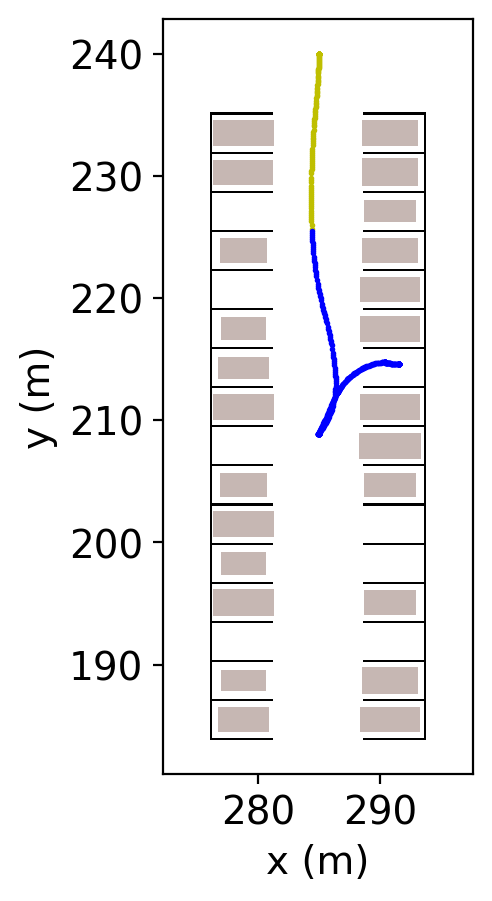

In [39]:
fig = plt.figure(figsize=(2, 5), dpi=200, facecolor='w', edgecolor='k')
ax = plt.gca()

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 14

# Line
for line_info in parking_lot:
    rect = patches.Rectangle((line_info[0]-line_info[2]/2, line_info[1]-line_info[3]/2),line_info[2],line_info[3],line_info[4], facecolor='k')
    ax.add_patch(rect)

# Static objects
for static_object in static_object_list:
    if static_object[0] < 275 or static_object[0] > 295:
        continue
    rect = patches.Rectangle((static_object[0]-static_object[2]/2, static_object[1]-static_object[3]/2),static_object[2],static_object[3],static_object[4], facecolor='#C6B7B3')
    ax.add_patch(rect)

for pose in ego_trajectory:
    
    if pose[-1] == -1:
        plt.plot(pose[1], pose[2], '.', markersize = 2, color = 'y')
    else:
        plt.plot(pose[1], pose[2], '.', markersize = 2, color = 'b')
    
    
plt.xlabel('x (m)')
plt.ylabel('y (m)')
    
plt.plot()
plt.axis('equal')
plt.show()

In [ ]:
# Get the data
pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
print('Found %d pkl files: %s' % (len(pklfiles_to_process), pklfiles_to_process))

file_num = 0

pklfile = pklfiles_to_process[file_num]

test_set  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}
test_set_kf  = {"history_traj_data" : None,
             "future_traj_data"  : None,
             "goal_position"     : None,
             "one_hot_goal"      : None}

test_set['history_traj_data'], test_set['future_traj_data'], test_set['goal_position'], test_set['one_hot_goal'], traj_idx = extract_data(pklfile, full_traj=True, crop_traj=True)
test_set_kf['history_traj_data'], test_set_kf['future_traj_data'], test_set_kf['goal_position'], test_set_kf['one_hot_goal'], traj_idx_kf = extract_data(pklfile, full_traj=True, crop_traj=False)

In [ ]:
# Build the model
history_shape = test_set['history_traj_data'].shape
goals_position_shape = test_set['goal_position'].shape
one_hot_goal_shape = test_set['one_hot_goal'].shape
future_shape = test_set['future_traj_data'].shape
hidden_dim = 100
beta = 0.
gamma = 10.
use_goal_info = True
comb_lstm = CombinedLSTM(history_shape, goals_position_shape, one_hot_goal_shape, future_shape, hidden_dim, beta, gamma, use_goal_info)
# comb_lstm.load('file_name')
# comb_lstm.goal_model.load()
# comb_lstm.traj_model.load()

In [ ]:
comb_lstm.fit(test_set, test_set,verbose=1)

In [ ]:
comb_lstm.save('./model/test')

In [ ]:
#comb_lstm.load('./model/LSTM_h100_b1.000_fold0')
comb_lstm.load('./model/test')

In [ ]:
top_k_goal = [0, 1, 2]
goal_pred, traj_pred_dict = comb_lstm.predict(test_set, top_k_goal=top_k_goal)
print(traj_pred_dict[0].shape)

In [ ]:
kf = EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)

In [ ]:
kf.load('./model/EKF_CV_fold0.pkl')
goal_pred, traj_pred_dict = kf.predict(test_set_kf)

In [ ]:
sup_plot('test_lstm', test_set, traj_idx, goal_pred, traj_pred_dict, limit=2)

In [ ]:
# for i in range(len(traj_idx) - 1)

# Plot the result
goal_ind = np.arange(33)
bar_width = 0.35
# Recover the goal coordinates
test_goals_coords = test_set['goal_position'].reshape((test_set['goal_position'].shape[0], 32, 3))
test_hist_traj    = test_set['history_traj_data']
test_future_traj  = test_set['future_traj_data']
test_one_hot_goal = test_set['one_hot_goal']

for num_traj in range(2):
    
    print("Start processing trajectory # %03d ....." % num_traj)
    start_idx = traj_idx[num_traj]
    end_idx   = traj_idx[num_traj+1]
    directory = './figures/%03d' % num_traj
    if not os.path.exists(directory):
        os.mkdir(directory)

    for i in range(start_idx, end_idx):

        fig = plt.figure(dpi=200)
        plt.suptitle('LSTM', va='center')
        plt.subplot(211)

        vector = test_goals_coords[i][-3,:2] - test_goals_coords[i][-1,:2]
        th = np.arctan2(vector[1], vector[0])
        R = np.array([[ np.cos(th), np.sin(th)], \
                      [-np.sin(th), np.cos(th)]])

        # Plot the vehicle trajectory in the snippet
        test_hist_traj_rot = test_hist_traj[i][:,:2] @ R.T
        test_future_traj_rot = test_future_traj[i][:,:2] @ R.T
        plt.plot(test_hist_traj_rot[:,0], test_hist_traj_rot[:,1], 'k')
        plt.plot(test_future_traj_rot[:,0], test_future_traj_rot[:,1], color = '#1f77b4')
        
        probs = goal_pred[i].copy()
        prob_undetermined = probs[-1]
        probs.sort()
        for top_k, traj_pred in traj_pred_dict.items():
            traj_pred_rot      = traj_pred[i][:, :2] @ R.T
            prob = probs[-1-top_k]
            plt.plot(traj_pred_rot[:,0], traj_pred_rot[:,1], '.', markersize = 3, color = '#ff770e', alpha= prob)

        # Plot the occupancy in the snippet
        test_goals_coords_rot = test_goals_coords[i][:,:2] @ R.T
        for goal, occup in zip(test_goals_coords_rot, test_goals_coords[i]):
            if occup[2] > 0:
                plt.plot(goal[0], goal[1], 'ko', fillstyle='none', markersize = 9)
            else:
                plt.plot(goal[0], goal[1], 'ko', markersize = 9)

        # Get the ground truth intention
        gt_idx = np.argmax(test_one_hot_goal[i])
        # Predictions above a threshold
        thres = 1e-2
        
        best_k_idx = [np.argsort(goal_pred[i])[-1-k] for k in top_k_goal]
#         best_k_idx = [k for k, p in enumerate(goal_pred[i]) if p >= thres]
#         print(np.max(goal_pred[i]))
        if gt_idx == 32: # If it is "-1" -> undetermined 
            plt.plot(0, 0, 'v', fillstyle='bottom', color = '#1f77b4', markersize = 9)
        else:
            plt.plot(test_goals_coords_rot[gt_idx][0], test_goals_coords_rot[gt_idx][1], 'o', fillstyle='bottom', color = '#1f77b4', markersize = 9)

        for j in best_k_idx:
            if j == 32:
                plt.plot(0, 0, 'v', fillstyle='none', color = '#ff770e', markersize = 9, alpha=prob_undetermined)
            else:
                plt.plot(test_goals_coords_rot[j][0], test_goals_coords_rot[j][1], 'o', fillstyle='none', color = '#ff770e', markersize = 9)

        plt.title('Trajectory and Spots in Ego Frame')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
    #     plt.axis('equal')

        plt.subplot(212)
        p1 = plt.bar(goal_ind - bar_width/2, test_one_hot_goal[i], bar_width, label='GT')
        p2 = plt.bar(goal_ind + bar_width/2, goal_pred[i], bar_width, label='Pred')
        plt.xlabel('Goal Index')
        plt.ylabel('Probability')
        plt.title('Likelihood of Selecting Different Goals')
        plt.legend()
        plt.tight_layout()
        
        
        fig.savefig('./figures/%03d/frame_%03d.png' % (num_traj, i-start_idx))
        plt.close(fig)
        
    fps = 2
    mv = os.system("ffmpeg -r {0:d} -i ./figures/{1:03d}/frame_%03d.png -vcodec mpeg4 -y ./figures/{1:03d}_movie.mp4".format(fps, num_traj) )
    if mv == 0:
        print("Trajectory # %03d movie saved successfully." % num_traj)
    else:
        print("Meet problem saving Trajectory # %03d movie." % num_traj)